# Backpropagation Part 1

The objective of this notebook is to compute gradients without the help of TensorFlow or PyTorch autograd. I will derive the gradients of 

- Affine transformation, a.k.a. Dense layer in TensorFlow Keras
- ReLU Activation
- Sigmoid Activation
- Mean Squared Error

## Demonstrate with TensorFlow

Let's start with how TensorFlow computes gradient with backpropagation. Here is a simple architecture with `input_shape=(3,3)` and `batch_size=1`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import RandomNormal, Zeros
from tensorflow.keras.losses import MeanSquaredError

2023-03-31 23:52:13.449607: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-31 23:52:13.567895: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-31 23:52:14.133972: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-31 23:52:14.134020: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
tf_model = Sequential([
    Dense(6, activation="relu", name="dense_1", kernel_initializer=RandomNormal(stddev=0.01), bias_initializer=Zeros()),
    Dense(3, activation="relu", name="dense_2", kernel_initializer=RandomNormal(stddev=0.01), bias_initializer=Zeros()),
    Dense(1, activation="sigmoid", name="dense_3", kernel_initializer=RandomNormal(stddev=0.01), bias_initializer=Zeros()),
])
tf_model.build((None, 1))
tf_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6)                 12        
                                                                 
 dense_2 (Dense)             (None, 3)                 21        
                                                                 
 dense_3 (Dense)             (None, 1)                 4         
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


2023-03-31 23:52:14.910889: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-31 23:52:14.916759: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-03-31 23:52:14.916777: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-03-31 23:52:14.917309: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neur

To keep things simple, I want my model to learn `sine` function. I define a L2 loss function. Since my model uses activation layers, the outputs should match that of `sine`.

$$
\text{sin}(x) = \text{model}(x) = \hat{y} \in [0, 1]
$$

Input:
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1]
Output: 
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
Loss:
 0.11601345


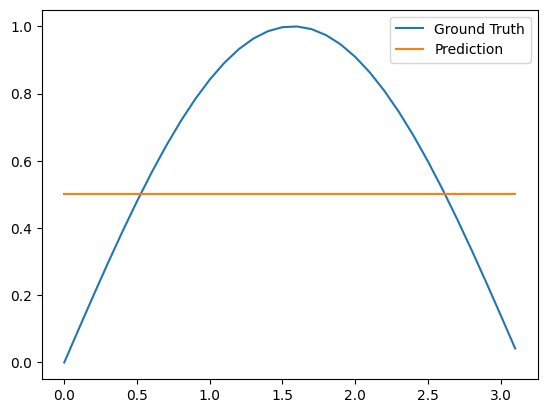

In [3]:
x = np.arange(0., 3.2, 0.1)
y_true = np.sin(x)

x = np.expand_dims(x, axis=-1)
y_true = np.expand_dims(y_true, axis=-1)

y_pred = tf_model(x).numpy()
mse = MeanSquaredError()
loss = mse(y_true, y_pred).numpy()

print("Input:\n", x.flatten())
print("Output: \n", np.round(y_pred, decimals=2).flatten())
print("Loss:\n", loss)
plt.plot(x.flatten(), y_true.flatten(), label="Ground Truth")
plt.plot(x.flatten(), y_pred.flatten(), label="Prediction")
plt.legend()

Compute gradients using TensorFlow.

In [4]:
with tf.GradientTape() as tape:
    y_pred = tf_model(x)
    loss = mse(y_true, y_pred)

print("MSE Loss Value:", loss.numpy())
gradients = tape.gradient(loss, tf_model.trainable_variables)
for var, grad in zip(tf_model.trainable_variables, gradients):
    print("Variable:", var.name)
    print("Gradient:\n", grad.numpy().round(decimals=5), "\n")

MSE Loss Value: 0.11601345
Variable: dense_1/kernel:0
Gradient:
 [[1.e-05 0.e+00 2.e-05 1.e-05 1.e-05 0.e+00]] 

Variable: dense_1/bias:0
Gradient:
 [1.e-05 0.e+00 1.e-05 0.e+00 1.e-05 0.e+00] 

Variable: dense_2/kernel:0
Gradient:
 [[ 0.e+00 -0.e+00  0.e+00]
 [ 0.e+00  0.e+00  0.e+00]
 [ 0.e+00 -2.e-05  3.e-05]
 [ 0.e+00 -0.e+00  0.e+00]
 [ 0.e+00 -0.e+00  1.e-05]
 [ 0.e+00  0.e+00  0.e+00]] 

Variable: dense_2/bias:0
Gradient:
 [ 0.      -0.00059  0.00094] 

Variable: dense_3/kernel:0
Gradient:
 [[ 0.e+00]
 [-3.e-05]
 [-5.e-05]] 

Variable: dense_3/bias:0
Gradient:
 [-0.06243] 



## Demonstrate with Numpy

Without the help of auto differentiation, now I need to write the same functionality with numpy and some calculus. I will use random normal weight initialization. Keep in mind that
`numpy` returns random normal distribution with `mean=0` and `std=1`. A new random normal distribution can be defined as follows.

$$
X^\prime = \sigma X + \mu
$$

In [5]:
from IPython.display import Code

from layers.dense import Dense
from layers.relu import ReLU
from layers.sigmoid import Sigmoid
from losses.mse import MeanSquaredError


class NumpyModel:
    """Model V1 will only perform forward propagation.
    """
    def __init__(self, weight_stddev=0.01):
        self.params = {
            "dense_1/kernel": weight_stddev * np.random.randn(1, 6),
            "dense_1/bias": np.zeros((6,)),
            "dense_2/kernel": weight_stddev * np.random.randn(6, 3),
            "dense_2/bias": np.zeros((3,)),
            "dense_3/kernel": weight_stddev * np.random.randn(3, 1),
            "dense_3/bias": np.zeros((1,)),
        }
        self.dense_1 = Dense()
        self.act_1 = ReLU()
        self.dense_2 = Dense()
        self.act_2 = ReLU()
        self.dense_3 = Dense()
        self.act_3 = Sigmoid()
        
    def __call__(self, x):
        x = self.dense_1(x, self.params['dense_1/kernel'], self.params['dense_1/bias'])
        x = self.act_1(x)
        x = self.dense_2(x, self.params['dense_2/kernel'], self.params['dense_2/bias'])
        x = self.act_2(x)
        x = self.dense_3(x, self.params['dense_3/kernel'], self.params['dense_3/bias'])
        x = self.act_3(x)
        return x

Now I have a model that produces the output and loss value like the TensorFlow model I setup above.

In [6]:
np_model = NumpyModel()
loss_fn = MeanSquaredError()

y_pred = np_model(x)
loss = loss_fn(y_true, y_pred)

print("Input:\n", x.flatten())
print("Output: \n", y_pred.flatten().round(decimals=5))
print("Loss:\n", loss.flatten())

Input:
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1]
Output: 
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
Loss:
 [0.11601298]


## Computing Gradient

### Gradient of Loss

The L2 loss is defined as follows.

$$
L = \frac{1}{N}\Sigma_{i=0}^{N-1} (y_{i} - \hat{y}_{i})^2
$$

The derivative of loss with respect to prediction is then:

$$
\frac{\partial L}{\partial \hat{y}} = \frac{2}{N} \cdot (y - \hat{y})
$$

In [7]:
Code(filename='losses/mse.py', language='python')

import numpy as np


class MeanSquaredError:
    def __init__(self):
        self.y_true = None
        self.y_pred = None

    def __call__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred
        return np.sum((y_true - y_pred)**2) / np.prod(y_pred.shape)

    def gradients(self):
        if self.y_pred is None:
            raise ValueError("loss function must be forward propagated first")

        grad_y = 2 * (self.y_pred - self.y_true)
        return grad_y

In [8]:
grad_y_pred = loss_fn.gradients()

### Gradient of Sigmoid

The activation of last layer is a sigmoid function.

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

The input `x` is the output from `dense_3` layer. Let's call it $A_3$, given that it's the output of an affine transformation. Then the derivative of sigmoid function or `y_pred` with respect to $A_3$ is:

$$
\frac{\partial \sigma}{\partial A_3} = (1 - \sigma(A_3)) * \sigma(A_3) =  \frac{\partial \hat{y}}{\partial A_3} = (1 - \hat{y}) * \hat{y}
$$

I want the gradient of loss with respect to $A_3$. I need to apply **chain rule** here.

$$
\frac{\partial L}{\partial A_3} = \frac{\partial L}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial A_3}
$$

In [9]:
Code(filename='layers/sigmoid.py', language='python')

import numpy as np


class Sigmoid:
    def __init__(self):
        self.x = None

    def __call__(self, x):
        """Perform forward propagation

        Args:
            x (np.ndarray): Input

        Returns:
            np.ndarray: Output
        """
        self.x = x
        return 1 / (1 + np.exp(-x))

    def gradients(self, grad_out):
        """Perofrm back propagation and return gradients with respect to upstream loss function.

        Args:
            grad_out (np.ndarray): Gradient of loss with respect to output.

        Returns:
            np.ndarray: Gradient of loss with respect to x
        """
        if self.x is None:
            raise ValueError("layer must be forward propagated first")
        
        y = self(self.x)
        return (1 - y) * y * grad_out

In [10]:
grad_affine_3 = np_model.act_3.gradients(grad_y_pred)
print("Affine 3 gradient shape", grad_affine_3.shape)

Affine 3 gradient shape (32, 1)


### Gradient of Trainable Variables

So far none of the gradients I have computed should be applied to any variable because the loss and activation functions above do not contain any parameters. However, I can use chain rules to **backpropagate** gradients to my trainable variables.
The first trainable variables, counting from the output, are `dense_3/kernel` and `dense_3/bias`. These two variables along with input from previous layer produces the affine output.

$$
A_3 = xW_3 + b_3 = \text{ReLU}(A_2)W_3 + b_3
$$

The gradient of affine with respect to kernel and bias are:

$$
\frac{\partial A_3}{\partial W_3} = x
$$

$$
\frac{\partial A_3}{\partial b_3} = 1
$$

But I am more interested in the gradient of loss with respect to kernel and bias. So I apply chain rule:

$$
\frac{\partial L}{\partial W_3} = \frac{\partial L}{\partial \hat{y}}\frac{\partial \hat{y}}{\partial A_3}\frac{\partial A_3}{\partial W_3} 
$$

$$
\frac{\partial L}{\partial b_3} = \frac{\partial L}{\partial \hat{y}}\frac{\partial \hat{y}}{\partial A_3}\frac{\partial A_3}{\partial b_3} 
$$

In [11]:
Code(filename='layers/dense.py', language='python')

import numpy as np


class Dense:
    def __init__(self):
        self.x = None
        self.w = None
        self.b = None

    def __call__(self, x, w, b):
        """Perform forward propagation

        Args:
            x (np.ndarray): Input
            w (np.ndarray): Kernel weights
            b (np.ndarray): Biases

        Returns:
            np.ndarray: Output
        """
        self.x = x
        self.w = w
        self.b = b
        return np.matmul(x, w) + b

    def gradients(self, grad_out):
        """Perform back propagation and return gradients with respect to upstream loss function.

        Args:
            grad_out (np.ndarray): Gradient of loss with respect to output.

        Returns:
            np.ndarray: Gradient of loss with respect to x
            np.ndarray: Gradient of loss with respect to w
            np.ndarray: Gradient of loss with respect to b
        """
        if self.x is None:
            raise ValueError("layer must be forward propagated first")
        
        grad_x = np.matmul(grad_out, self.w.T)
        grad_w = np.matmul(self.x.T, grad_out)
        grad_b = np.sum(grad_out, axis=0)
        return grad_x, grad_w, grad_b

In [12]:
grad_affine_2_act, grad_dense_3_kernel, grad_dense_3_bias = np_model.dense_3.gradients(grad_affine_3)
print("Dense 3 kernel shape", np_model.params['dense_3/kernel'].shape)
print("Dense 3 kernel gradient shape", grad_dense_3_kernel.shape)
print("Dense 3 bias shape", np_model.params['dense_3/bias'].shape)
print("Dense 3 bias gradient shape", grad_dense_3_bias.shape)
print("Affine 2 gradient shape", grad_affine_2_act.shape)

Dense 3 kernel shape (3, 1)
Dense 3 kernel gradient shape (3, 1)
Dense 3 bias shape (1,)
Dense 3 bias gradient shape (1,)
Affine 2 gradient shape (32, 3)


Repeat the same process for `dense_2` layer. However, I have `ReLU` activation and its gradient is slightly different from sigmoid activation.

$$
\frac{\partial \text{ReLU}}{\partial x} = \frac{\partial \text{ReLU}}{\partial A_2} = \begin{cases}
1 & \text{ if } x \gt 0 \\ 
0 & \text{ else }  
\end{cases}
$$

What I need is

$$
\frac{\partial L}{\partial A_2} = \frac{\partial L}{\partial \hat{y}}\frac{\partial \hat{y}}{\partial A_3}\frac{\partial A_3}{\partial \;\text{ReLU}} \frac{\partial \text{ReLU}}{\partial A_2}
$$

In [13]:
grad_affine_2 = np_model.act_2.gradients(grad_affine_2_act)
print("Affine 2 gradient shape", grad_affine_2.shape)

Affine 2 gradient shape (32, 3)


Then I can compute the gradients of layer 2 kernel weights and bias.

$$
\frac{\partial L}{\partial W_2} = \frac{\partial L}{\partial A_2} \frac{\partial A_2}{\partial W_2}
$$


In [14]:
grad_affine_1_act, grad_dense_2_kernel, grad_dense_2_bias = np_model.dense_2.gradients(grad_affine_2)
print("Dense 2 kernel shape", np_model.params['dense_2/kernel'].shape)
print("Dense 2 kernel gradient shape", grad_dense_2_kernel.shape)
print("Dense 2 bias shape", np_model.params['dense_2/bias'].shape)
print("Dense 2 bias gradient shape", grad_dense_2_bias.shape)

Dense 2 kernel shape (6, 3)
Dense 2 kernel gradient shape (6, 3)
Dense 2 bias shape (3,)
Dense 2 bias gradient shape (3,)


Finally, repeat the same process for `dense_1` layer.

In [15]:
grad_affine_1 = np_model.act_1.gradients(grad_affine_1_act)
print("Affine 1 gradient shape", grad_affine_1.shape)

Affine 1 gradient shape (32, 6)


In [16]:
_, grad_dense_1_kernel, grad_dense_1_bias = np_model.dense_1.gradients(grad_affine_1)
print("Dense 1 kernel shape", np_model.params['dense_1/kernel'].shape)
print("Dense 1 kernel gradient shape", grad_dense_1_kernel.shape)
print("Dense 1 bias shape", np_model.params['dense_1/bias'].shape)
print("Dense 1 bias gradient shape", grad_dense_1_bias.shape)

Dense 1 kernel shape (1, 6)
Dense 1 kernel gradient shape (1, 6)
Dense 1 bias shape (6,)
Dense 1 bias gradient shape (6,)


Look at the values of all the gradients computed.

In [17]:
print("Dense 3 kernel gradients\n", grad_dense_3_kernel)
print("Dense 3 bias gradients\n", grad_dense_3_bias)
print("Dense 2 kernel gradients\n", grad_dense_2_kernel)
print("Dense 2 bias gradients\n", grad_dense_2_bias)
print("Dense 1 kernel gradients\n", grad_dense_1_kernel)
print("Dense 1 bias gradients\n", grad_dense_1_bias)

Dense 3 kernel gradients
 [[ 0.        ]
 [-0.00037297]
 [ 0.        ]]
Dense 3 bias gradients
 [-1.99773925]
Dense 2 kernel gradients
 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.89278553e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
Dense 2 bias gradients
 [ 0.00101865 -0.00155859 -0.00390116]
Dense 1 kernel gradients
 [[ 0.00000000e+00  0.00000000e+00 -3.97477991e-05  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
Dense 1 bias gradients
 [-1.16921800e-05  5.27640970e-05  1.04120766e-05  7.51411323e-05
  2.82114962e-05  1.51971140e-05]


## Optimization

In [18]:
from optimizers.adam import Adam

In [102]:
optim = Adam(learning_rate=1e-3)
np_model = NumpyModel()
loss_fn = MeanSquaredError()
x = np.expand_dims(np.arange(0., 1, 0.01), axis=-1)
print("Input", x.shape)
y_true = np.sin(x)
print("Expected output", y_true.shape)

Input (100, 1)
Expected output (100, 1)


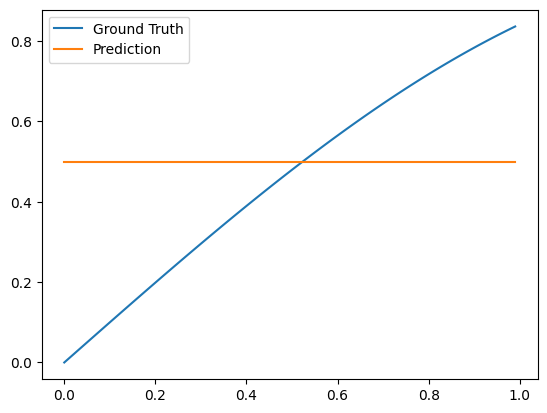

In [103]:
y_pred = np_model(x)
plt.plot(x.flatten(), y_true.flatten(), label="Ground Truth")
plt.plot(x.flatten(), y_pred.flatten(), label="Prediction")
plt.legend()

In [104]:
batch_size = 20
steps = x.shape[0] // batch_size
for epoch in range(10000):
    
    y_pred = np_model(x)
    loss = loss_fn(y_true, y_pred)

    for i in range(1, steps):
        start, end = (i - 1) * batch_size, i * batch_size
        batch_x = x[start:end]
        batch_y_true = y_true[start:end]
        batch_y_pred = np_model(batch_x)
        loss = loss_fn(batch_y_true, batch_y_pred)
        grad_affine_3_act = loss_fn.gradients()
        grad_affine_3 = np_model.act_3.gradients(grad_affine_3_act)
        grad_affine_2_act, grad_dense_3_kernel, grad_dense_3_bias = np_model.dense_3.gradients(grad_affine_3)
        grad_affine_2 = np_model.act_2.gradients(grad_affine_2_act)
        grad_affine_1_act, grad_dense_2_kernel, grad_dense_2_bias = np_model.dense_2.gradients(grad_affine_2)
        grad_affine_1 = np_model.act_1.gradients(grad_affine_1_act)
        _, grad_dense_1_kernel, grad_dense_1_bias = np_model.dense_1.gradients(grad_affine_1)
        grads = {
            "dense_1/kernel": grad_dense_1_kernel,
            "dense_1/bias": grad_dense_1_bias,
            "dense_2/kernel": grad_dense_2_kernel,
            "dense_2/bias": grad_dense_2_bias,
            "dense_3/kernel": grad_dense_3_kernel,
            "dense_3/bias": grad_dense_3_bias,
        }
        for key in grads:
            optim.update(i, key, np_model.params, grads)

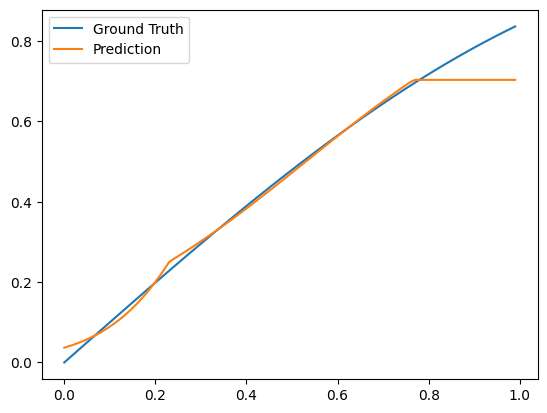

In [105]:
y_pred = np_model(x)
plt.plot(x.flatten(), y_true.flatten(), label="Ground Truth")
plt.plot(x.flatten(), y_pred.flatten(), label="Prediction")
plt.legend()

The model is now overfitted to the training data. I have very few training data points so I had to force overfit.